0.3333333333333333


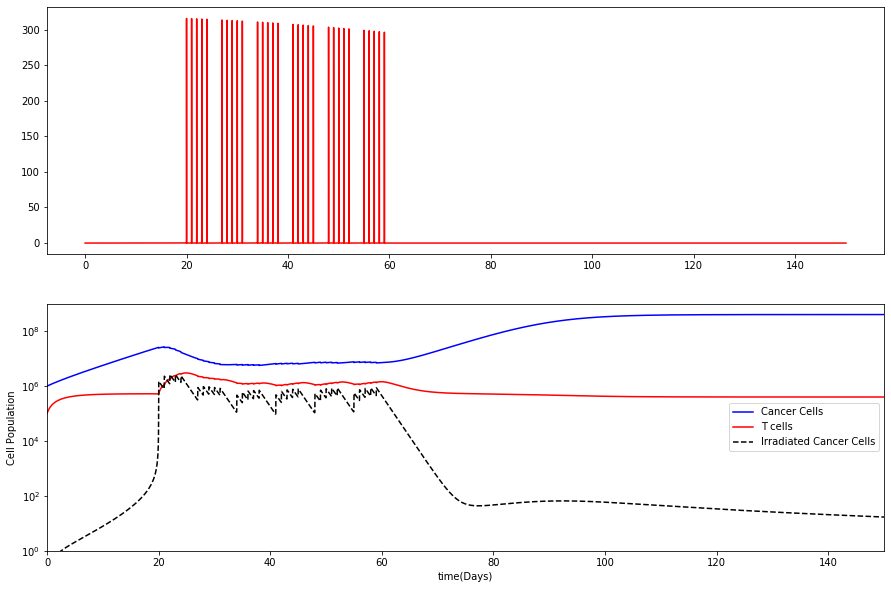

In [46]:
#Radiotherapy model by JCL Alfonso, Jan Poleszczuk, Rachel Walker, et al.
#"Immunologic consequences of sequencing cancer radiotherapy and surgery"
#2019
from scipy.integrate import odeint, quad
import numpy as np
import matplotlib.pyplot as plt
import math

#Parameters
DAYS = 150      #How many days to simulate
epsilon = 0.001 #Width of dirac delta function

r  = 0.23      #Tumour growth rate (1/day)
k  = 5.32e8     #Tumour tissue carrying capacity (Cells)
a  = 0.14e-6    #T-cell-Cancer interaction constant
p  = 0.998      #Probability that Cancer dies during T-cell-Cancer interaction
f  = 0.26       #Magnitude of immune system stimulation by the presence of cancer cells
g  = 0.16e6     #Immune stimulation damping coeffecient
h  = 0.59       #Effector cell decay rate
E1 = 0.3e6      #Physiologic level of effector cells
q  = 0.65       #RT-induced immunostimulation
n  = 0.69       #Lysis rate of tumour cells killed by RT
al = 0.3        #Radiation sensitivity parameter
be = 0.03       #Radiation sensitivity parameter
zp = 1        #Radiosensitivity of proliferative cancer cells
zq = 1./3       #Radiosensitivity of quiescent cancer cells
ze = 0.68       #Radiosensitivity of effector t cells
d  = 2          #Radiation dose
lc = 0.99
le = 0.99
 
t_i = [20,21,22,23,24, 27,28,29,30,31, 34,35,36,37,38, 41,42,43,44,45, 48,49,50,51,52, 55,56,57,58,59]      #Time of radiation
t_j = [70]       #Time of surgery


#Model
def model(x,t):
    C = x[0]
    E = x[1]
    D = x[2]
    if C < 1:
        dCdt = 0
    else:
        dCdt = r*C*(1 - (C+D)/k) - a*p*E*C - dirac(t)*radioTherapy_C(C, D) #- dirac(t_j, t)*surgery_C(C)
    dEdt = f*E*C/(g+C) - a*(1-p)*E*C + h*(E1-E) + q*D  - dirac(t)*radioTherapy_E(E) # - dirac(t_j, t)*surgery_E(E)
    dDdt = dirac(t)*radioTherapy_C(C, D) - n*D

    return [dCdt, dEdt, dDdt]

normal = (1/quad(diracE, -np.inf, np.inf)[0])
def dirac(t):
    answer = 0
    answer += diracE(t)*normal
    return answer
    
def SF(z, d): #Surviving fraction of irradiated cancer cells
    return np.exp(-z*(al*d+be*d**2))
    
def radioTherapy_C(C, D):
    return (1 - SF(zp, d))*C*(1-(C + D)/k) + ((1 - SF(zq, d))*C*((C+D)/k))

def radioTherapy_E(E):
    return (1 - SF(ze, d))*E

def surgery_E(E):
    return le*E

def surgery_C(C):
    return lc*C

diracE = lambda t: sum([(1/(math.pi))*(epsilon)/((epsilon**2)+(t - i)**2) for i in t_i]) 

#plotting
x0 = [1e6, 1e5, 0]
t = np.linspace(0,DAYS, DAYS*24*60) #Each timespace is 1 sec
diracE_values = [diracE(s) for s in t]
x = odeint(model,x0,t)

C = x[:,0]
E = x[:,1]
D = x[:,2]

fig = plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.plot(t,diracE_values,'r-')

plt.subplot(2,1,2)

axes = plt.gca()
axes.set_ylim([1,10e8])
axes.set_xlim([0,DAYS])
plt.semilogy(t,C,'b-', label = 'Cancer Cells')
plt.semilogy(t,E,'r-', label = 'T cells' )
plt.semilogy(t,D,'k--', label = 'Irradiated Cancer Cells')
plt.xlabel('time(Days)')
plt.ylabel('Cell Population')
plt.legend()

